<a href="https://colab.research.google.com/github/Farhan-slurrp/grab-app-sentiment-analysis/blob/main/grab_reviews_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Grab App Review Sentiment Analysis using Deep Learning**

This project it to perform sentiment analysis on review comment for Grab. The dataset is downloaded from: https://www.kaggle.com/datasets/bwandowando/grab-app-reviews-from-google-store

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
import io

df = pd.read_csv('/content/drive/MyDrive/datasets/GRAB_REVIEWS.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441620 entries, 0 to 441619
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           441620 non-null  int64 
 1   review_text          441468 non-null  object
 2   review_rating        441620 non-null  int64 
 3   author_id            441548 non-null  object
 4   author_name          441620 non-null  object
 5   author_app_version   373360 non-null  object
 6   review_datetime_utc  441620 non-null  object
 7   review_likes         441620 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 27.0+ MB


In [ ]:
df = df.drop(columns=[df.columns[0], 'author_id', 'author_name', 'review_likes']);

In [ ]:
df = df.dropna(subset=['review_text'])

In [ ]:
# drop neutral review
df = df[df['review_rating'] != 3]

In [ ]:
# Map 1-2 review into Negative, and 4-5 into Positive, not as good as manual human label.
target_map = {1: 'negative', 2: 'negative', 4: 'positive', 5: 'positive'}
df['target'] = df['review_rating'].map(target_map)

target_map = {'negative': 0, 'positive' : 1}
df['target_binary'] = df['target'].map(target_map)

In [ ]:
df.head()

,review_text,review_rating,author_app_version,review_datetime_utc,target,target_binary
0,Great app!,5,NaN,2013-05-31T16:03:05.000Z,positive,1
1,Super like,5,v2.0,2013-06-09T03:37:35.000Z,positive,1
2,This app makes it easy to find a cab. Drivers ...,5,v2.0,2013-06-12T11:58:10.000Z,positive,1
3,Great experience!,5,v2.0,2013-06-16T17:55:07.000Z,positive,1
4,Very convenient. Cool.,5,v2.0,2013-06-26T23:24:03.000Z,positive,1


In [ ]:
df.columns = ['text', 'score','app_version','date','target','target_binary']

In [ ]:
import re

# Define a function to clean the version
def clean_version(version):
    # Use regular expression to extract the version number
    match = re.match(r'(?:v)?(\d+)\.\d+', str(version))
    if match:
        return match.group(1)
    else:
        return None


In [ ]:
df['app_version_cut'] = df['app_version'].apply(clean_version)

In [ ]:
!pip install seaborn

<Axes: xlabel='target', ylabel='count'>

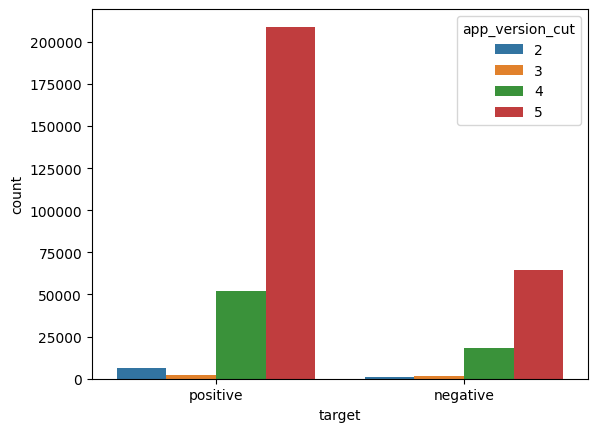

In [ ]:
import seaborn as sns

sns.countplot(data=df, x='target', hue='app_version_cut')

<Axes: xlabel='target', ylabel='count'>

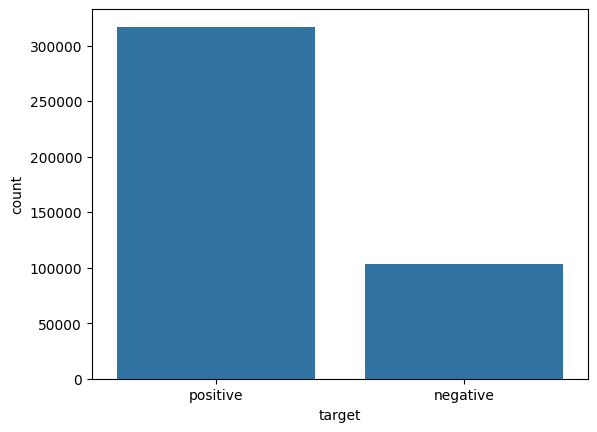

In [ ]:
sns.countplot(data=df, x='target')

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['text_processed'] = df['text'].apply(lemmatizer.lemmatize)

In [ ]:
nltk.download('punkt')

def tokenize_text(text):
    # removing extra whitespaces
    text = text.strip()
    tokens = nltk.word_tokenize(text)
    # removing any number and symbol tokens
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

df['tokens'] = df['text_processed'].apply(tokenize_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
nltk.download('stopwords')

def remove_stopword(tokens):
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwords]
    return tokens

df['tokens_without_stopword'] = df['tokens'].apply(remove_stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
# number of classes
K = df['target_binary'].max() + 1
K

2

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

In [ ]:
MAX_VOCAB_SIZE = 3000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['tokens_without_stopword'])
sequences_train = tokenizer.texts_to_sequences(df_train['tokens_without_stopword'])
sequences_test = tokenizer.texts_to_sequences(df_test['tokens_without_stopword'])

In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 53701 unique tokens.


In [ ]:
# pad sequences to get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# sequence length
T = data_train.shape[1]

Shape of data train tensor: (281290, 310)


In [ ]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (138547, 310)


**CNN**

In [ ]:
D = 10

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(16, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 310)]             0         
                                                                 
 embedding (Embedding)       (None, 310, 10)           537020    
                                                                 
 conv1d (Conv1D)             (None, 308, 16)           496       
                                                                 
 global_max_pooling1d (Glob  (None, 16)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
Total params: 537550 (2.05 MB)
Trainable params: 537550 (2.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________

In [ ]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  df_train['target_binary'],
  epochs=5,
  validation_data=(data_test, df_test['target_binary'])
)

Training model...
Epoch 1/5
8791/8791 [==============================] - 124s 14ms/step - loss: 0.2069 - accuracy: 0.9211 - val_loss: 0.1900 - val_accuracy: 0.9300
Epoch 2/5
8791/8791 [==============================] - 116s 13ms/step - loss: 0.1813 - accuracy: 0.9335 - val_loss: 0.1871 - val_accuracy: 0.9313
Epoch 3/5
8791/8791 [==============================] - 126s 14ms/step - loss: 0.1732 - accuracy: 0.9374 - val_loss: 0.1868 - val_accuracy: 0.9320
Epoch 4/5
8791/8791 [==============================] - 127s 14ms/step - loss: 0.1667 - accuracy: 0.9398 - val_loss: 0.1888 - val_accuracy: 0.9309
Epoch 5/5
8791/8791 [==============================] - 127s 14ms/step - loss: 0.1612 - accuracy: 0.9424 - val_loss: 0.1917 - val_accuracy: 0.9297


In [ ]:
import matplotlib.pyplot as plt

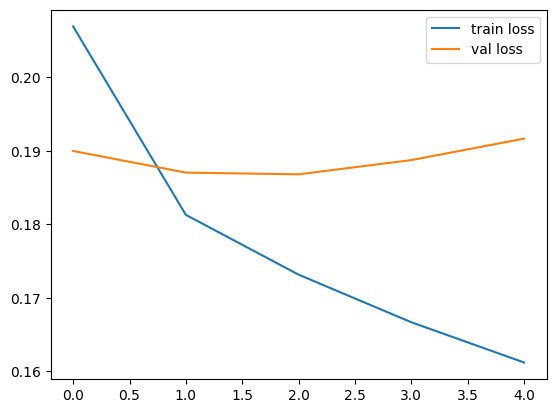

In [ ]:
# plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

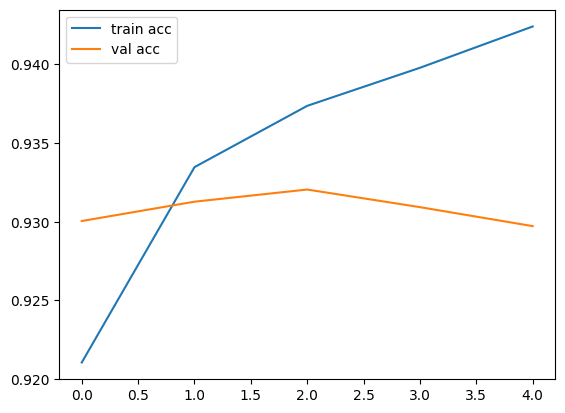

In [ ]:
# plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [ ]:
import numpy as np

sentiment = ['Negative','Positive']

In [ ]:
# test positive
sequence = tokenizer.texts_to_sequences(['the app has many features that usable for me'])
test = pad_sequences(sequence, maxlen=T)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 21ms/step


'Positive'

In [ ]:
sequence = tokenizer.texts_to_sequences(['very buggy'])
test = pad_sequences(sequence, maxlen=T)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 21ms/step


'Negative'